# Train GammaNet with PyTorch

In [1]:
import sys
import numpy as np
import h5py
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
sys.path.append("/home/liponan/projects/gammanet/")
from gammanet.simulate import sim_detector_image


## Dataset

### Define a dataset class

In [2]:
class PhotonImages(Dataset):
    
    def __init__(self, data_h5, tensor=True):
        self.tensor = tensor
        with h5py.File(data_h5, "r") as f:
            self.imgs = f["imgs"][:]
            self.labels = f["labels"][:]
            self.nhits = f["nhits"][:]
            
    def __len__(self):
        return self.imgs.shape[0]
    
    def make_label(self, idx):
        label = np.zeros( (3, self.imgs.shape[1], self.imgs.shape[2]) )
        for i in range(self.nhits[idx]):
            ix = int(round(self.labels[idx,i,0]))
            iy = int(round(self.labels[idx,i,1]))
            if ix >= label.shape[2] or iy >= label.shape[1]:
                continue
            offset_x = self.labels[idx,i,0] - ix
            offset_y = self.labels[idx,i,1] - iy
            label[0, iy, ix] = 1
            label[1, iy, ix] = offset_y
            label[2, iy, ix] = offset_x
        return label
    
    def __getitem__(self, idx):
        img = self.imgs[np.newaxis,idx,:,:]
        label = self.make_label(idx)
        if self.tensor:
            img = torch.from_numpy(img)
            label = torch.from_numpy(label)
        return img, label
        

### Test Dataset

In [3]:
train_dataset = PhotonImages("train.h5")
x, y = train_dataset[0]
print("x", x.size())
print("y", y.size())

x torch.Size([1, 32, 32])
y torch.Size([3, 32, 32])


Text(0.5, 1.0, 'y-offset')

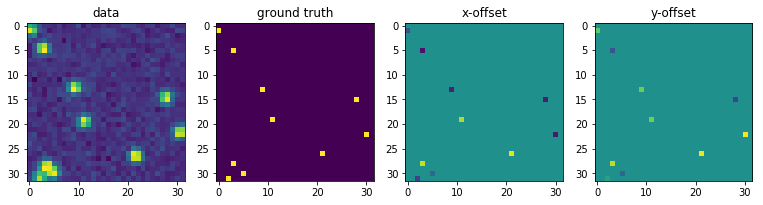

In [4]:
fig = plt.figure()
fig.set_size_inches(13, 4)
plt.subplot(1, 4, 1)
plt.imshow(x[0,:,:])
plt.title("data")
plt.subplot(1, 4, 2)
plt.imshow(y[0,:,:])
plt.title("ground truth")
plt.subplot(1, 4, 3)
plt.imshow(y[1,:,:], vmin=-0.5, vmax=0.5)
# plt.colorbar()
plt.title("x-offset")
plt.subplot(1, 4, 4)
plt.imshow(y[2,:,:], vmin=-0.5, vmax=0.5)
plt.title("y-offset")
# plt.colorbar()


### Setup a Dataloader

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=2)

## Loss function

## Network

In [6]:
def GammaNetLoss(scores, target, entropy=True):
    if entropy:
        loss = nn.BCEWithLogitsLoss()(scores.float(), target.float())
    else:
        scores = nn.Sigmoid()(scores)
        loss = nn.MSELoss()(scores.float(), target.float())
    return loss

In [7]:
test_loss = GammaNetLoss(torch.rand(4,1,16,16), torch.rand(4,1,16,16))

### Define network

In [8]:
class conv1x1(nn.Module):
    def __init__(self, n_in, n_out, activate=False, stride=1, bias=True):
        super(conv1x1, self).__init__()
        self.conv1 = nn.Conv2d(n_in, n_out, kernel_size=1, stride=stride, padding=0, bias=bias)
        torch.nn.init.kaiming_normal_( self.conv1.weight )
        self.bn1 = torch.nn.BatchNorm2d(n_out)
        nn.init.constant_(self.bn1.weight, 1)
        nn.init.constant_(self.bn1.bias, 0)
        self.activate = activate

    def forward(self,x):
        x = self.bn1(self.conv1(x))
        if self.activate:
            x = F.relu(x)
        return x    

class conv3x3(nn.Module):
    def __init__(self, n_in, n_out, activate=True, stride=1, bias=True):
        super(conv3x3, self).__init__()
        self.conv1 = nn.Conv2d(n_in, n_out, kernel_size=3, stride=stride, padding=1, bias=bias)
        torch.nn.init.kaiming_normal_( self.conv1.weight )
        self.bn1 = torch.nn.BatchNorm2d(n_out)
        nn.init.constant_(self.bn1.weight, 1)
        nn.init.constant_(self.bn1.bias, 0)
        self.activate = activate

    def forward(self,x):
        x = self.bn1(self.conv1(x))
        if self.activate:
            x = F.relu(x)
        return x


class GammaNet(nn.Module):
    def __init__(self, n_filters, n_hidden, n_in, n_out):
        super(GammaNet, self).__init__()
        self.input = conv3x3(n_in, n_filters)
        self.output = conv1x1(n_filters, n_out)
        layer = conv3x3(n_filters, n_filters)
        self.hidden = nn.Sequential(
            *[layer for i in range(n_hidden-1)]
        )
        
    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        return x

### Print net arch

In [33]:
model = GammaNet(n_filters=64, n_hidden=2, n_in=1, n_out=1)
print(model)

GammaNet(
  (input): conv3x3(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): conv1x1(
    (conv1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (hidden): Sequential(
    (0): conv3x3(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)


## Train the network

### Parameters

In [34]:
use_cuda = True
gpu_id = "cuda:1"
n_epochs = 500
lr = 0.01
lr_policy = 200
l2_lambda = 1e-4

### Optimizer

In [35]:
optimizer = optim.Adam

### Validation dataset

In [36]:
val_dataset = PhotonImages("val.h5")
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=1)

### Run

In [37]:
if use_cuda:
    model.to(gpu_id)
    
seen = 0
train_loss_list = []
val_loss_list = []
    
for epoch in range(n_epochs):
    if epoch % lr_policy == 0 and epoch > 0:
        lr /= 10.0
        print("======== LR is now {} ==========".format(lr))
    for i, (x,y) in enumerate(train_dataloader):
        my_optimizer = optimizer(model.parameters(), lr=lr, weight_decay=l2_lambda)
        if use_cuda:
            x = x.to(gpu_id)
            y = y.to(gpu_id)
        model.train()
        my_optimizer.zero_grad()
        scores = model(x)
        loss = GammaNetLoss(scores, y[:,[0],:,:], entropy=True)
        loss.backward()
        my_optimizer.step()
        seen += x.size(0)
#         print("epoch", epoch, "iteration", i, "seen", seen, "loss", float(loss.data))
        train_loss_list.append((seen, float(loss.data)))
    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_seen = 0
        for j, (x,y) in enumerate(val_dataloader):
            if use_cuda:
                x = x.to(gpu_id)
                y = y.to(gpu_id)
            scores = model(x)
            loss = GammaNetLoss(scores, y[:,[0],:,:], entropy=True)
            val_seen += x.size(0)
            val_loss += x.size(0) * float(loss.data)
        val_loss /= val_seen
        val_loss_list.append((seen, val_loss))
        print("epoch", epoch, "seen", seen, "val. loss", float(val_loss))
            

epoch 0 seen 10240 val. loss 0.5433353781700134
epoch 1 seen 20480 val. loss 0.5158210396766663
epoch 2 seen 30720 val. loss 0.4779682159423828
epoch 3 seen 40960 val. loss 0.4502204656600952
epoch 4 seen 51200 val. loss 0.41598525643348694
epoch 5 seen 61440 val. loss 0.3842364549636841
epoch 6 seen 71680 val. loss 0.35881665349006653
epoch 7 seen 81920 val. loss 0.33012455701828003
epoch 8 seen 92160 val. loss 0.30356550216674805
epoch 9 seen 102400 val. loss 0.2783781886100769
epoch 10 seen 112640 val. loss 0.25197112560272217
epoch 11 seen 122880 val. loss 0.2299622893333435
epoch 12 seen 133120 val. loss 0.20945289731025696
epoch 13 seen 143360 val. loss 0.1926116794347763
epoch 14 seen 153600 val. loss 0.17581331729888916
epoch 15 seen 163840 val. loss 0.16196471452713013
epoch 16 seen 174080 val. loss 0.1477544605731964
epoch 17 seen 184320 val. loss 0.13716468214988708
epoch 18 seen 194560 val. loss 0.1251947283744812
epoch 19 seen 204800 val. loss 0.13335978984832764
epoch 20 

epoch 157 seen 1617920 val. loss 0.006794322282075882
epoch 158 seen 1628160 val. loss 0.006776317022740841
epoch 159 seen 1638400 val. loss 0.006840703543275595
epoch 160 seen 1648640 val. loss 0.006740876939147711
epoch 161 seen 1658880 val. loss 0.006800769828259945
epoch 162 seen 1669120 val. loss 0.006746647879481316
epoch 163 seen 1679360 val. loss 0.006783840246498585
epoch 164 seen 1689600 val. loss 0.006786595098674297
epoch 165 seen 1699840 val. loss 0.006742401979863644
epoch 166 seen 1710080 val. loss 0.006773204542696476
epoch 167 seen 1720320 val. loss 0.006740710698068142
epoch 168 seen 1730560 val. loss 0.006750549655407667
epoch 169 seen 1740800 val. loss 0.006709665060043335
epoch 170 seen 1751040 val. loss 0.006773248314857483
epoch 171 seen 1761280 val. loss 0.006789551582187414
epoch 172 seen 1771520 val. loss 0.006794579327106476
epoch 173 seen 1781760 val. loss 0.006794460117816925
epoch 174 seen 1792000 val. loss 0.00674395402893424
epoch 175 seen 1802240 val. l

epoch 309 seen 3174400 val. loss 0.0047412654384970665
epoch 310 seen 3184640 val. loss 0.004716021940112114
epoch 311 seen 3194880 val. loss 0.004730838350951672
epoch 312 seen 3205120 val. loss 0.00472368486225605
epoch 313 seen 3215360 val. loss 0.004739787429571152
epoch 314 seen 3225600 val. loss 0.004746489692479372
epoch 315 seen 3235840 val. loss 0.004673974588513374
epoch 316 seen 3246080 val. loss 0.004701923578977585
epoch 317 seen 3256320 val. loss 0.004704701714217663
epoch 318 seen 3266560 val. loss 0.004654427990317345
epoch 319 seen 3276800 val. loss 0.004686719737946987
epoch 320 seen 3287040 val. loss 0.004689032677561045
epoch 321 seen 3297280 val. loss 0.004698330070823431
epoch 322 seen 3307520 val. loss 0.004720126278698444
epoch 323 seen 3317760 val. loss 0.00469987653195858
epoch 324 seen 3328000 val. loss 0.0046983929350972176
epoch 325 seen 3338240 val. loss 0.004686116706579924
epoch 326 seen 3348480 val. loss 0.0047083208337426186
epoch 327 seen 3358720 val.

epoch 461 seen 4730880 val. loss 0.004247210919857025
epoch 462 seen 4741120 val. loss 0.004248504992574453
epoch 463 seen 4751360 val. loss 0.004257879685610533
epoch 464 seen 4761600 val. loss 0.004229554440826178
epoch 465 seen 4771840 val. loss 0.004240694921463728
epoch 466 seen 4782080 val. loss 0.004233969375491142
epoch 467 seen 4792320 val. loss 0.004223045893013477
epoch 468 seen 4802560 val. loss 0.004230857826769352
epoch 469 seen 4812800 val. loss 0.004231082275509834
epoch 470 seen 4823040 val. loss 0.004232652019709349
epoch 471 seen 4833280 val. loss 0.004225177690386772
epoch 472 seen 4843520 val. loss 0.004252220503985882
epoch 473 seen 4853760 val. loss 0.004221928771585226
epoch 474 seen 4864000 val. loss 0.004232632461935282
epoch 475 seen 4874240 val. loss 0.004237349610775709
epoch 476 seen 4884480 val. loss 0.00423799455165863
epoch 477 seen 4894720 val. loss 0.004226261749863625
epoch 478 seen 4904960 val. loss 0.0042342147789895535
epoch 479 seen 4915200 val. 

In [38]:
np.array(train_loss_list).shape

(5000, 2)

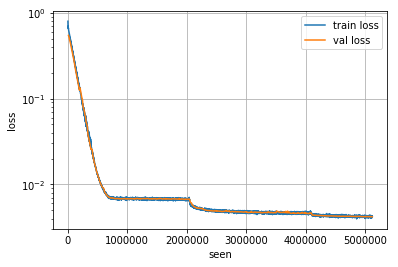

In [39]:
fig = plt.figure()
plt.semilogy(np.array(train_loss_list)[:,0], np.array(train_loss_list)[:,1], label="train loss")
plt.semilogy(np.array(val_loss_list)[:,0], np.array(val_loss_list)[:,1], label="val loss")
plt.xlabel("seen")
plt.ylabel("loss")
plt.legend()
plt.grid()

### Visualize on-the-fly data

In [40]:
with torch.no_grad():
    x_np = x.cpu().numpy()
    y_np = y.cpu().numpy()
    scores_np = nn.Sigmoid()(scores).cpu().detach().numpy()

Text(0.5, 1.0, 'prediction')

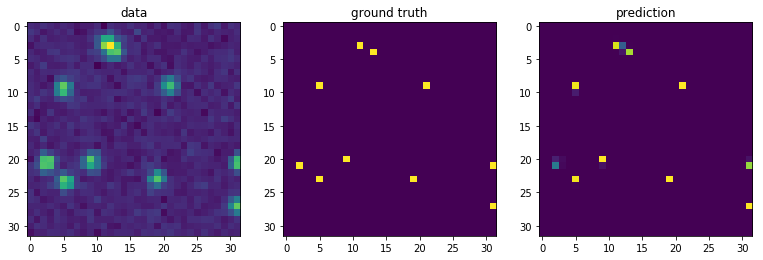

In [41]:
fig = plt.figure()
fig.set_size_inches(13, 4)
plt.subplot(1, 3, 1)
plt.imshow(x_np[0,0,:,:])
plt.title("data")
plt.subplot(1, 3, 2)
plt.imshow(y_np[0,0,:,:], vmin=0, vmax=1)
plt.title("ground truth")
plt.subplot(1, 3, 3)
plt.imshow(scores_np[0,0,:,:], vmin=0, vmax=1)
plt.title("prediction")